# Bayesian Missing Value Imputation: A Computational Approach

## Introduction

Missing data is one of the most common challenges in statistical modeling and data analysis. Whether due to non-responses in surveys, sensor failures, or data corruption, the absence of values can bias results, reduce statistical power, and distort inferences.

This notebook demonstrates the functionality of the `BayesianImputer` Python module, developed for Bayesian missing value imputation using MCMC methods (Gibbs sampling, Metropolis-Hastings) and Bayesian regression.

It supports:
- MCAR and MAR missingness simulation
- Bayesian multiple imputation
- Posterior diagnostics and visualization
- Overfitting evaluation

Unlike simple techniques like mean or mode imputation, Bayesian methods allow us to generate multiple imputations drawn from a posterior predictive distribution — a practice that helps preserve data variability and integrity.

## Objectives

This notebook accompanies a Python module that performs missing value imputation using Bayesian principles. The project is designed to:

- Simulate missing data under different mechanisms (MCAR, MAR)
- Perform **MCMC-based imputation** using:
  - Gibbs Sampling
  - Metropolis-Hastings
- Implement **Bayesian regression imputation**
- Visualize the quality and uncertainty of imputations
- Evaluate risk of **overfitting** under increasing missingness
- Compare results to PyMC’s built-in missing value imputation

## Why Bayesian?

Bayesian frameworks are especially attractive for imputation because:
- They allow for flexible incorporation of **prior knowledge**
- They naturally provide **multiple imputations** from posterior distributions
- They support **uncertainty quantification** via credible intervals
- They are increasingly accessible through probabilistic programming tools like PyMC

Throughout this notebook, we demonstrate the use of a custom `BayesianImputer` class to handle missing data in a principled and transparent manner.


In [2]:
# Imports
from bayes_impute import BayesianImputer
import pandas as pd
import numpy as np

## Dataset and Simulation

### Dataset Description

To validate Bayesian imputation methods under controlled conditions, we simulate a clean dataset with continuous variables representing:

- `age`: Normally distributed around 30
- `income`: Normally distributed around 60,000
- `score`: Normally distributed around 75 (e.g., credit score, exam score, etc.)

This synthetic setup ensures known data relationships and lets us evaluate imputation accuracy under different missingness mechanisms.

We'll demonstrate:
- **MCAR (Missing Completely at Random)** — data missing independently of other values.
- **MAR (Missing at Random)** — data missing conditional on another variable.

Let's preview the dataset and simulate missingness.


In [3]:
np.random.seed(410)

# Simulate clean data
df_full = pd.DataFrame({
    'age': np.random.normal(30, 5, 100),
    'income': np.random.normal(60000, 8000, 100),
    'score': np.random.normal(75, 10, 100)
})

df_with_missing = df_full.copy()
threshold = df_with_missing['age'].median()
mar_rows = df_with_missing[df_with_missing['age'] > threshold].sample(frac=0.2, random_state=42)
missing_mask = mar_rows.index
df_with_missing.loc[missing_mask, 'income'] = np.nan

df_with_missing.head()

,age,income,score
0,31.519445,62383.921027,77.433816
1,34.092600,50345.956560,85.714520
2,34.752894,61180.797853,70.880755
3,29.776711,62095.778723,80.088106
4,30.054022,81041.730531,72.021625


### Simulating Missingness with `BayesianImputer`

We now apply our custom `BayesianImputer` module to simulate missing values under a **Missing at Random (MAR)** mechanism. In this case, the probability that a value is missing depends on another observed variable.

This step uses the `simulate_missing()` method and helps us benchmark imputation performance later. We also use `detect_missing_mechanism()` to summarize missingness patterns before imputation.


## Initializing the Imputer (Gibbs & Metropolis-Hastings)

To demonstrate the flexibility of our `BayesianImputer` module, we initialize two separate imputer instances:

- One using **Gibbs Sampling**
- One using **Metropolis-Hastings**

We simulate missing data under the same MAR mechanism for both, then initialize missing values using mean imputation before proceeding with Bayesian inference.


In [4]:
# ➤ Gibbs Imputer Setup
df_gibbs_data = df_with_missing.copy()
imputer_gibbs = BayesianImputer(df_gibbs_data, mechanism='MAR', method='gibbs')
imputer_gibbs.simulate_missing(mechanism='MAR', percent=0.2)

# View a summary of missing values per column
imputer_gibbs.detect_missing_mechanism()

imputer_gibbs.initialize_missing()

[Init] BayesianImputer initialized with method='gibbs', mechanism='MAR', imputations=5
[Simulate Missing] Applied MAR mechanism with 20.0% missingness.
[Detect] Missing value count per column:
age        0
income    10
score      9
dtype: int64
[InitMissing] Missing values initialized using column means.


In [5]:
# ➤ Metropolis-Hastings Imputer Setup
df_mh_data = df_with_missing.copy()
imputer_mh = BayesianImputer(df_mh_data, mechanism='MAR', method='metropolis')
imputer_mh.simulate_missing(mechanism='MAR', percent=0.2)

# View a summary of missing values per column
imputer_mh.detect_missing_mechanism()

imputer_mh.initialize_missing()

[Init] BayesianImputer initialized with method='metropolis', mechanism='MAR', imputations=5
[Simulate Missing] Applied MAR mechanism with 20.0% missingness.
[Detect] Missing value count per column:
age       10
income    10
score      0
dtype: int64
[InitMissing] Missing values initialized using column means.


## Bayesian Imputation and Diagnostics

In this section, we use our custom imputer to generate multiple posterior samples of the missing values using:

- **Gibbs Sampling**
- **Metropolis-Hastings**

We then assess the imputation quality and convergence behavior using visualization and diagnostic tools.


[Impute] Running gibbs sampling...
[Gibbs] Starting Gibbs sampling...
[Gibbs] Imputation 1 completed.
[Gibbs] Imputation 2 completed.
[Gibbs] Imputation 3 completed.
[Gibbs] Imputation 4 completed.
[Gibbs] Imputation 5 completed.
[Gibbs] Gibbs sampling finished.
[Impute] Imputation complete.
[Visualize Imputations] Generating plots for observed vs. imputed distributions...


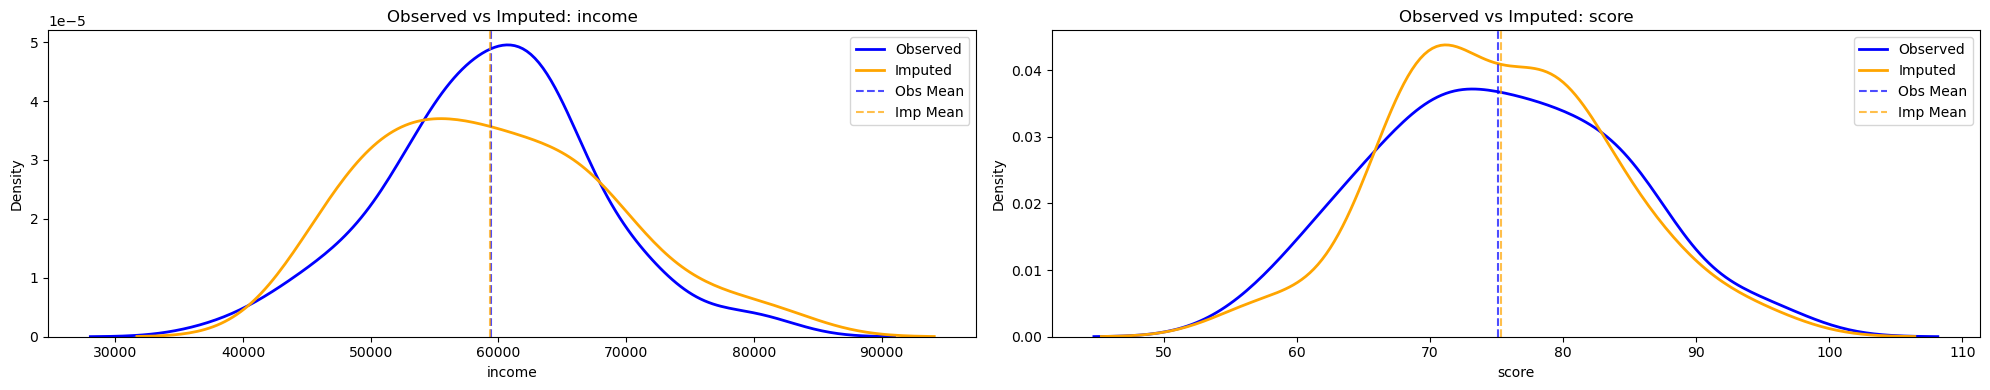

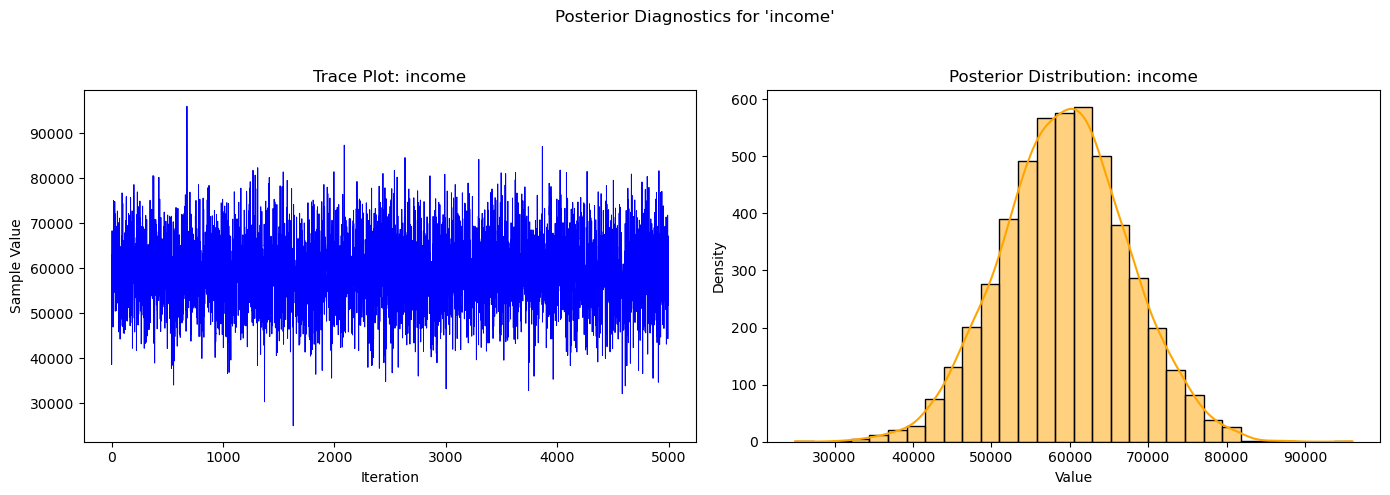

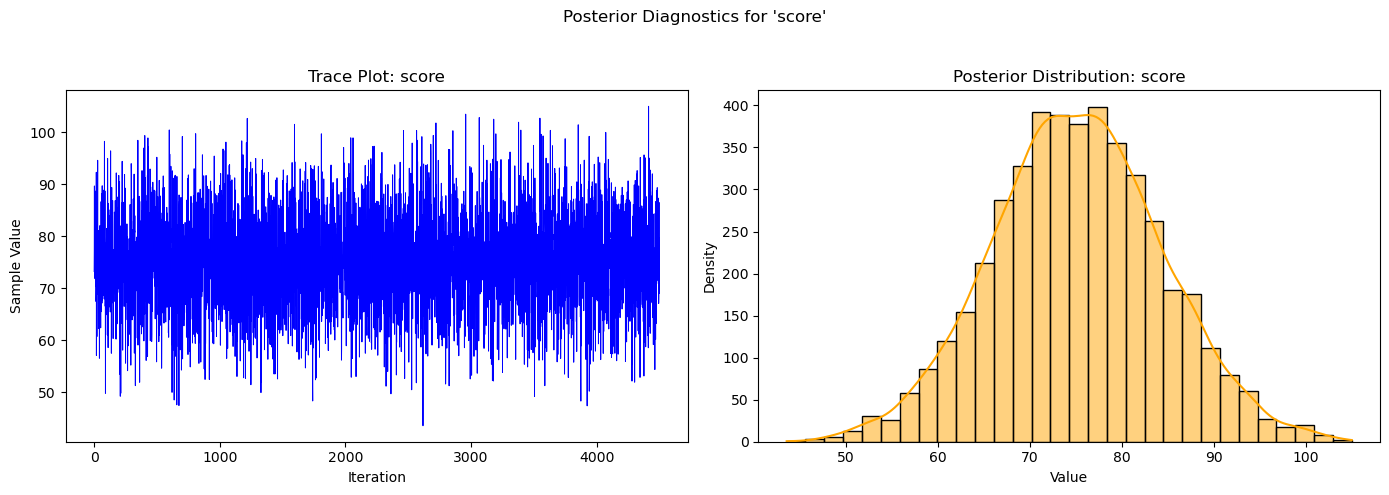

[Overfitting Evaluation]
 - income: RMSE=nan, Coverage=0.00%, Width=20140.0720
 - score: RMSE=11.4996, Coverage=44.44%, Width=18.2718


{'income': {'RMSE': nan,
  'Coverage_95%': 0.0,
  'Avg_Credible_Interval_Width': 20140.071986910556},
 'score': {'RMSE': 11.499564613164905,
  'Coverage_95%': 0.4444444444444444,
  'Avg_Credible_Interval_Width': 18.271787606357258}}

In [6]:
# ➤ Gibbs Sampling Imputation
imputer_gibbs.generate_multiple_imputations()
imputer_gibbs.visualize_imputations()
imputer_gibbs.posterior_diagnostics()
imputer_gibbs.evaluate_overfitting()


### TODO: Add comments regarding plots

[Impute] Running metropolis sampling...
[MH] Starting Metropolis-Hastings sampling...
[MH] Imputation 1 completed.
[MH] Imputation 2 completed.
[MH] Imputation 3 completed.
[MH] Imputation 4 completed.
[MH] Imputation 5 completed.
[MH] Metropolis-Hastings sampling finished.
[Impute] Imputation complete.
[Visualize Imputations] Generating plots for observed vs. imputed distributions...


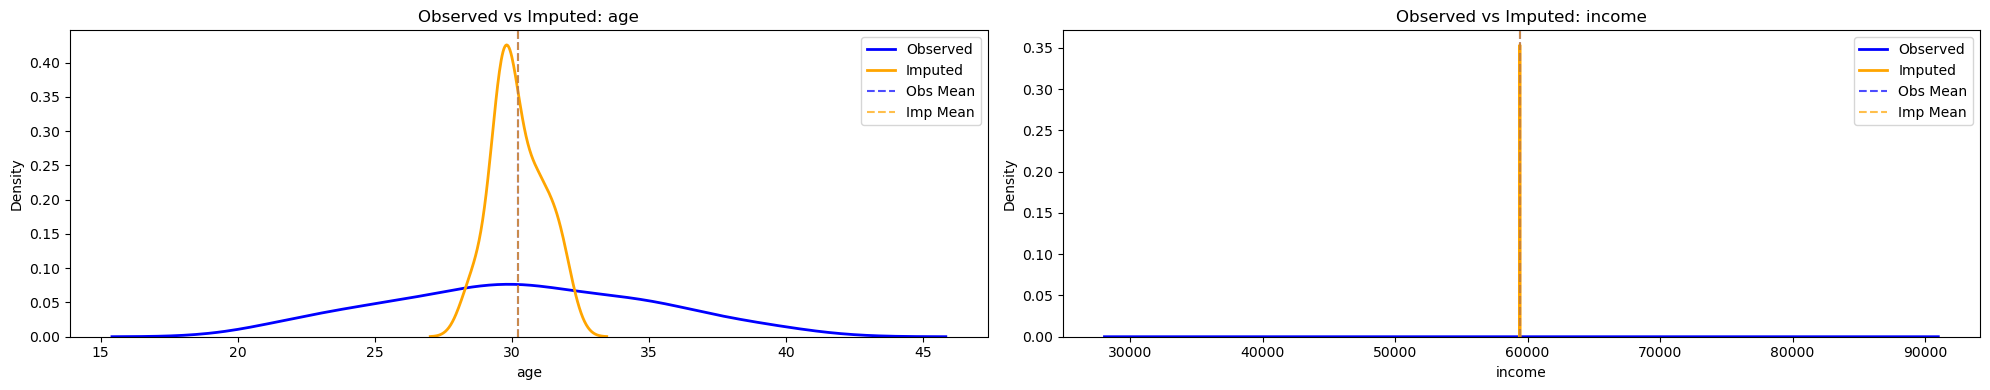

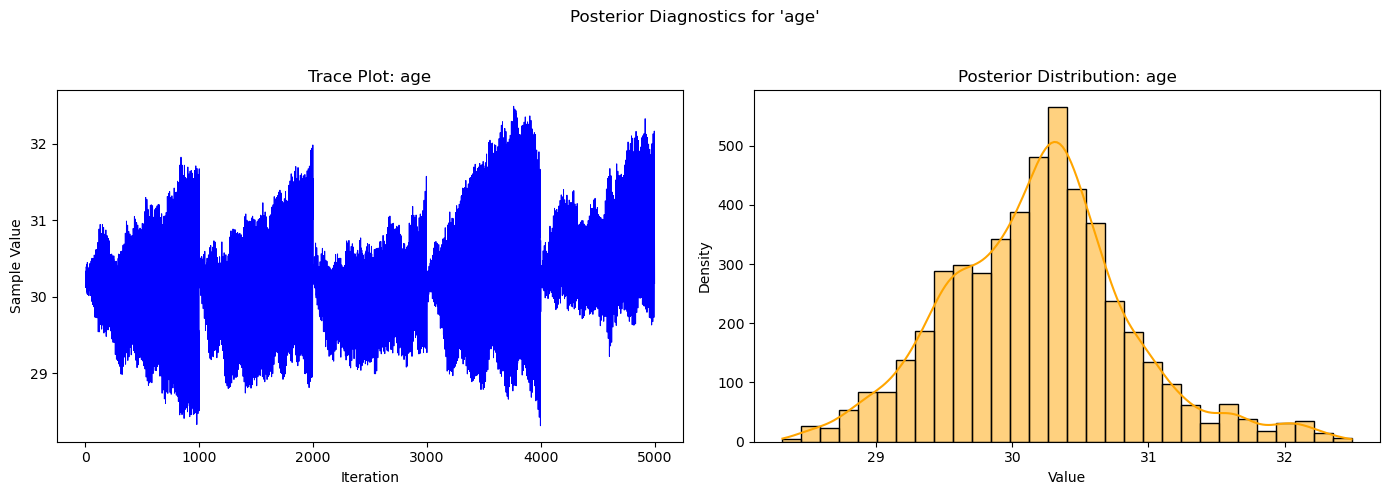

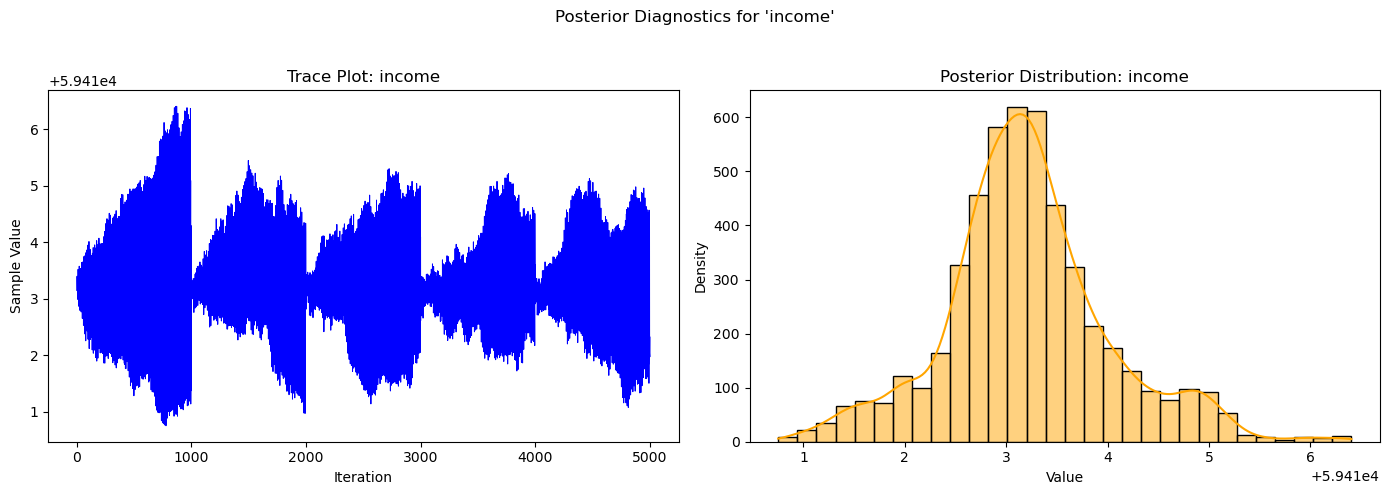

[Overfitting Evaluation]
 - age: RMSE=4.6417, Coverage=10.00%, Width=2.2117
 - income: RMSE=nan, Coverage=0.00%, Width=2.5755


{'age': {'RMSE': 4.641745013577092,
  'Coverage_95%': 0.1,
  'Avg_Credible_Interval_Width': 2.2117152214277085},
 'income': {'RMSE': nan,
  'Coverage_95%': 0.0,
  'Avg_Credible_Interval_Width': 2.575547308108071}}

In [7]:
# ➤ Metropolis-Hastings Imputation
imputer_mh.generate_multiple_imputations()
imputer_mh.visualize_imputations()
imputer_mh.posterior_diagnostics()
imputer_mh.evaluate_overfitting()


## Comparison with PyMC

To validate our implementation, we compare the imputed values and uncertainty estimates against **PyMC**, a popular probabilistic programming framework for Bayesian inference.

We'll use PyMC to model one of the features with missing data (e.g., `income`) using observed predictors, then compare its imputations to those generated by our custom imputer.


In [31]:
# Standardize for PyMC
df_stdzd = df_with_missing.copy()
df_stdzd['age'] = (df_stdzd['age'] - df_stdzd['age'].mean()) / df_stdzd['age'].std()
df_stdzd['score'] = (df_stdzd['score'] - df_stdzd['score'].mean()) / df_stdzd['score'].std()

X1 = df_stdzd['age'].values
X2 = df_stdzd['score'].values
y = df_stdzd['income'].values

observed_idx = ~np.isnan(y)
missing_idx = np.isnan(y)

with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=60000, sigma=10000)
    beta_age = pm.Normal("beta_age", mu=0, sigma=5000)
    beta_score = pm.Normal("beta_score", mu=0, sigma=5000)
    sigma = pm.HalfNormal("sigma", sigma=5000)

    mu = alpha + beta_age * X1 + beta_score * X2
    y_obs = pm.Normal("y_obs", mu=mu[observed_idx], sigma=sigma, observed=y[observed_idx])
    y_miss = pm.Normal("y_miss", mu=mu[missing_idx], sigma=sigma)

    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age, beta_score, sigma, y_miss]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


### Imputing `income` with PyMC

We now use PyMC to model `income` as a function of observed covariates `age` and `score`. PyMC automatically handles missing data by treating them as latent variables and sampling from their posterior distributions.



Unique values in Gibbs imputed income: [56797.60080549 75354.00120434 52780.2169461  60042.27728062
 52522.84096833 54484.63099371 45235.19199523 59279.77076389
 60965.32072135 50178.27530197]
Unique values in MH imputed income: [59414.50479749 59414.29034089 59411.89472066 59411.37192937
 59416.36651601 59412.73887104 59411.13615076 59415.08982469
 59412.28000555 59413.66867047]


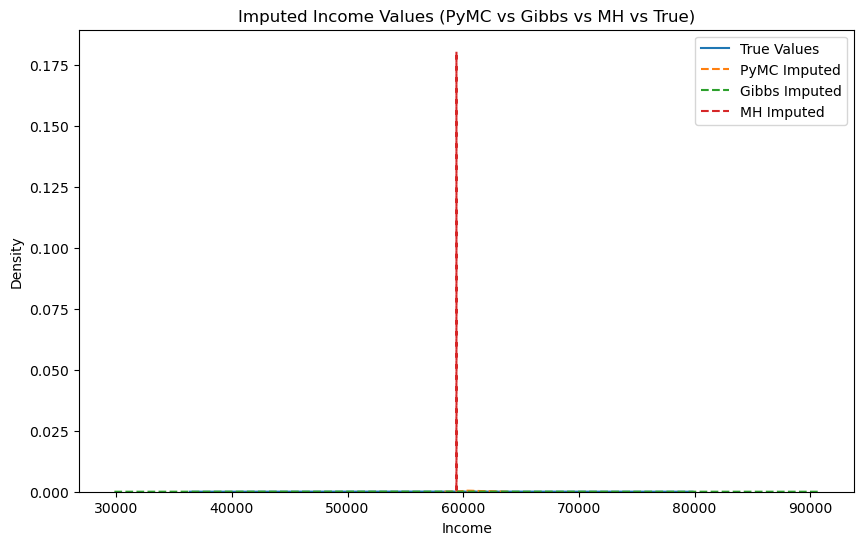

RMSE:
  PyMC : 6527.679786498446
  Gibbs: 9295.430820928443
  MH   : 6157.368405648262


In [33]:
# Extract posterior means
posterior_means = trace.posterior["y_miss"].stack(draws=("chain", "draw")).mean("draws").values
pymc_imputed_income = df_with_missing['income'].copy()
pymc_imputed_income.loc[missing_mask] = posterior_means

# Extract other imputed values
gibbs_vals = imputer_gibbs.imputed_datasets[0].loc[missing_mask, 'income']
mh_vals = imputer_mh.imputed_datasets[0].loc[missing_mask, 'income']
pymc_vals = pymc_imputed_income.loc[missing_mask]
true_vals = df_full.loc[missing_mask, 'income']

print("Unique values in Gibbs imputed income:", gibbs_vals.unique())
print("Unique values in MH imputed income:", mh_vals.unique())


# Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(true_vals, label="True Values", linestyle='-')
sns.kdeplot(pymc_vals, label="PyMC Imputed", linestyle='--')
sns.kdeplot(gibbs_vals, label="Gibbs Imputed", linestyle='--')
sns.kdeplot(mh_vals, label="MH Imputed", linestyle='--')
plt.title("Imputed Income Values (PyMC vs Gibbs vs MH vs True)")
plt.xlabel("Income")
plt.ylabel("Density")
plt.legend()
plt.show()

# RMSE
print("RMSE:")
print("  PyMC :", np.sqrt(np.mean((pymc_vals - true_vals)**2)))
print("  Gibbs:", np.sqrt(np.mean((gibbs_vals - true_vals)**2)))
print("  MH   :", np.sqrt(np.mean((mh_vals - true_vals)**2)))


### PyMC Imputation Pipeline: Comparison to Custom Module

This next section demonstrates how to replicate our custom Bayesian imputation workflow using **PyMC**, a probabilistic programming library that provides flexible MCMC inference.

1. **Dataset Preparation**  
   A fresh copy of the clean dataset (`df_full`) is created. We simulate **MAR (Missing At Random)** missingness in the `income` variable based on the median of `age`, mimicking realistic patterns of missing data.

2. **Missingness Summary**  
   We use `.isnull().sum()` to print a quick summary of missing values in each column—this mirrors the `detect_missing_mechanism()` method from our custom module.

3. **Data Standardization**  
   PyMC performs better with standardized predictors, so we scale `age` and `score` to have mean 0 and variance 1. This avoids numerical instability during sampling.

4. **Model Specification in PyMC**  
   A Bayesian linear regression model is defined:
   - Priors are set for the intercept (`alpha`), coefficients (`beta_age`, `beta_score`), and noise (`sigma`)
   - Observed values are conditioned directly using `y_obs`
   - Missing values are treated as latent variables via `y_miss`

5. **MCMC Sampling**  
   Using `pm.sample`, we perform posterior inference over the model parameters and the missing income values.

6. **Posterior Imputation**  
   The imputed values for missing income are obtained by taking the **posterior mean** of the `y_miss` variable across all MCMC draws.

7. **Data Reconstruction**  
   A copy of the dataset with missing values is filled using the imputed posterior means to produce `pymc_imputed_df`.

8. **Visualization**  
   We visualize the imputed income distribution against the original clean data using `seaborn.kdeplot`. This allows a direct comparison between true and imputed distributions, echoing our module's `visualize_imputations()`.

---

**Purpose:** This workflow allows us to **benchmark** our custom `BayesianImputer` module by comparing its output to that of a well-established probabilistic inference library.


In [9]:
import pymc as pm
import arviz as az

# 1. Copy clean data
df_pymc_data = df_full.copy()

# 2. Simulate MAR missingness manually for 'income'
np.random.seed(42)
threshold = df_pymc_data['age'].median()
mar_rows = df_pymc_data[df_pymc_data['age'] > threshold].sample(frac=0.2, random_state=1)
df_pymc_data.loc[mar_rows.index, 'income'] = np.nan

# 3. Print missing summary (like detect_missing_mechanism)
print("[PyMC] Missing value count per column:")
print(df_pymc_data.isnull().sum())


[PyMC] Missing value count per column:
age        0
income    10
score      0
dtype: int64


In [10]:
# 4. Prepare for PyMC
df_stdzd = df_pymc_data.copy()
df_stdzd['age'] = (df_stdzd['age'] - df_stdzd['age'].mean()) / df_stdzd['age'].std()
df_stdzd['score'] = (df_stdzd['score'] - df_stdzd['score'].mean()) / df_stdzd['score'].std()

X1 = df_stdzd['age'].values
X2 = df_stdzd['score'].values
y = df_stdzd['income'].values

observed_idx = ~np.isnan(y)
missing_idx = np.isnan(y)


In [11]:
# 5. Run PyMC imputation
with pm.Model() as pymc_model:
    alpha = pm.Normal("alpha", mu=60000, sigma=10000)
    beta_age = pm.Normal("beta_age", mu=0, sigma=5000)
    beta_score = pm.Normal("beta_score", mu=0, sigma=5000)
    sigma = pm.HalfNormal("sigma", sigma=5000)

    mu = alpha + beta_age * X1 + beta_score * X2

    y_obs = pm.Normal("y_obs", mu=mu[observed_idx], sigma=sigma, observed=y[observed_idx])
    y_miss = pm.Normal("y_miss", mu=mu[missing_idx], sigma=sigma)

    pymc_trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age, beta_score, sigma, y_miss]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


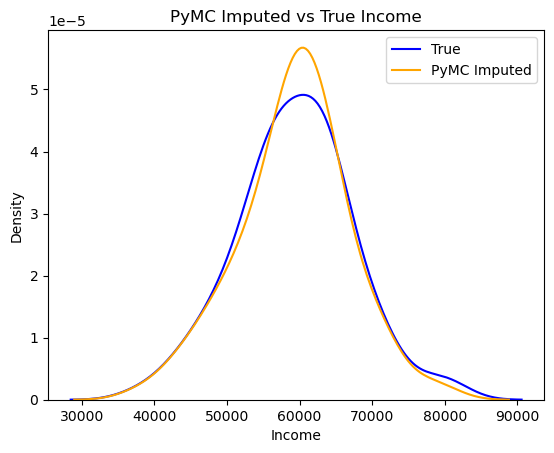

In [12]:
# 6. Get posterior mean imputations
posterior_means = pymc_trace.posterior["y_miss"].stack(draws=("chain", "draw")).mean("draws").values

# 7. Fill in imputed values
pymc_imputed_df = df_pymc_data.copy()
pymc_imputed_df.loc[missing_idx, 'income'] = posterior_means

# 8. Visualize distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(df_full['income'], label='True', color='blue')
sns.kdeplot(pymc_imputed_df['income'], label='PyMC Imputed', color='orange')
plt.title("PyMC Imputed vs True Income")
plt.xlabel("Income")
plt.ylabel("Density")
plt.legend()
plt.show()
